# Transfer Learning with ResNet

Transfer learning is a powerful technique used in deep learning, where a network trained for one task (general image classification over multiple classes) is adapted to another (classification over just two classes). This allows for a vastly smaller dataset of not more than a few hundred images, and thus for a much faster training.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

A pretrained ResNet-50 model is created using `torchvision.models` subpackage.

In [2]:
transfer_model = models.resnet50(pretrained=True)

The idea here is not to perform training as it was the case with architectures initialized with random parameters. A pretrained network presumably already knows a lot about the problem it is being applied to and to properly re-train it massive amounts of data are needed. It is precisely the unavailability of such quantities of data that motivate us to reach out for transfer learning technique.

What happens instead is the replacement of the standard 1,000-category linear layer doing the ImageNet classification in ResNet-50 architecture with a new block which will be trained for the task at hand, namely classification of images into only two categories. This is achived by freezing all the existing ResNet layers which allows for training only the newly added ones, with the frozen layers still passing activations.

IRO `("bn" not in name)` condition - it is preferable not to freeze the BatchNorm layers ina  model as they will be trained to approximate the mean and standard deviation of the dataset that the model was originally trained on, not the dataset that it is being fine-tuned on. For that reason these are also trained alongside the newly added classifier.

In [3]:
for name, param in transfer_model.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False

Classifier is replaced using the same `nn.Sequential()` chain as it was the case with CNNNet.

Parameter `transfer_model.fc.in_features` allows for grabbing the number of activations coming into a layer instead of explicitely stating the number. Same could be done with `out_features`.

In [4]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2))

In [5]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(outputs), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'
             .format(epoch, training_loss, valid_loss, num_correct / num_examples))

In [6]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    
img_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
    ])

train_data_path = "/Users/nikolavetnic/Desktop/Datasets/img_catfish/train/"
train_data = torchvision.datasets.ImageFolder(
    root=train_data_path,
    transform=img_transforms,
    is_valid_file=check_image)

val_data_path = "/Users/nikolavetnic/Desktop/Datasets/img_catfish/val/"
val_data = torchvision.datasets.ImageFolder(
    root=val_data_path,
    transform=img_transforms,
    is_valid_file=check_image)

test_data_path = "/Users/nikolavetnic/Desktop/Datasets/img_catfish/test/"
test_data = torchvision.datasets.ImageFolder(
    root=test_data_path,
    transform=img_transforms,
    is_valid_file=check_image)

batch_size = 64

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
print(len(val_data_loader.dataset))

111


In [8]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [9]:
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=5, device=device)

/Users/nikolavetnic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 0.55, Validation Loss: 0.21, accuracy = 0.91
Epoch: 1, Training Loss: 0.18, Validation Loss: 0.20, accuracy = 0.91
Epoch: 2, Training Loss: 0.07, Validation Loss: 0.22, accuracy = 0.91
Epoch: 3, Training Loss: 0.02, Validation Loss: 0.15, accuracy = 0.94
Epoch: 4, Training Loss: 0.01, Validation Loss: 0.19, accuracy = 0.91


In [10]:
labels = ['cat', 'fish']

url = "https://images.theconversation.com/files/243439/original/file-20181101-83635-1xcrr39.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img_transforms(img).to(device)

predicted_class = labels[torch.argmax(transfer_model(img.unsqueeze(0)))]
print(predicted_class)

cat


# Learning Rate Finder

Although the learning rate value of 0.001 works well most of the time there is an exact method of determining the best float for our current architecture. The idea is as follows: over the course of an epoch the training starts out with a small learning rate and increases to a higher learning rate over each mini-batch, resulting in a high rate at the end of the epoch. The loss is then calculated for each rate and plotted - by looking at the plot we are searching for the learning rate that gives not the minimum value but the greatest decline.

One thing to note is that this function actually trains the model in the process and changes the optimizers learning rates. For that reason the model is to be saved before running it and reloaded afterwards.

In [11]:
# saving the parameters using state_dict
torch.save(transfer_model.state_dict(), "/Users/nikolavetnic/Desktop/DeepLearning/TransferLearning_wResNet/resnet_state_dict")

In [12]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    
    for data in train_loader:
        batch_num += 1
        optimizer.zero_grad()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        # crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            if (len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses
        
        # record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss
            
        # store the values
        losses.append(loss.item())
        log_lrs.append((lr))
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    
    if (len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

First bits of training and the last few (especially if the learning rate becomes very large quite quickly) tend to not tell us much information, hence we return slices of `log_lrs` and `losses`.

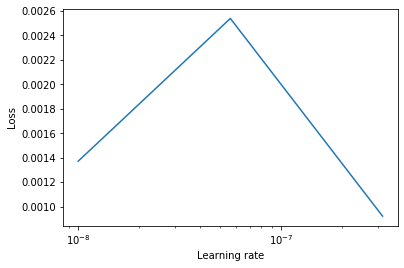

In [13]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(), optimizer, train_data_loader, device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [14]:
# loading the parameters using state_dict
resnet_state_dict = torch.load("/Users/nikolavetnic/Desktop/DeepLearning/TransferLearning_wResNet/resnet_state_dict")
transfer_model.load_state_dict(resnet_state_dict)

<All keys matched successfully>

# Custom transforms

Here a transform that will randomly change the image color space from RGB into HSV. PIL library provides `Image.convert()` which we can use to translate an image from one color space to another. The custom transform function will be then wrapped in a `transforms.Lambda` provided by PyTorch and thus made available to the transform pipeline.

In [15]:
def _random_color_space(x):
    output = x.convert("HSV")
    return output

color_transform = transforms.Lambda(lambda x: _random_color_space(x))

random_color_transform = torchvision.transforms.RandomApply([color_transform])

In case a lambda isn't enought it is possible to create a custom transform that operates on either PIL image data or a tensor. Such a class has to implement two methods: `__call__`, which transform pipeline will invoke during the transformation process, and `__repr__`, which should return a string representation of the transform, along with any state that may be useful for diagnostics.

`torch.zeros_like()` returns a tensor filled with the scalar value `0`, with the same size as `input`. `torch.zeros_like(input)` is equivalent to `torch.zeros(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)`.

`normal_` fills the given 2-dimensional matrix with values drawn from a normal distribution parameterized by `mean` and `std`.

In [16]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    """
    
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev
        
    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        
    def __repr__(self):
        repr = f"{self.__class__.__name__ }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [17]:
custom_transform_pipeline = transforms.Compose([random_color_transform, Noise(0.1, 0.05)])

# Ensembles

Given a list of models, we can produce predictions for each model and then make an average to make a final prediction.

This is something I have to research further as I have just copied the code from the book.

In [18]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

/Users/nikolavetnic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [19]:
avg_prediction

tensor(916)

In [20]:
torch.stack(predictions)

tensor([[[0.0014, 0.0010, 0.0013,  ..., 0.0016, 0.0009, 0.0007]],

        [[0.0009, 0.0004, 0.0011,  ..., 0.0011, 0.0009, 0.0007]]],
       grad_fn=<StackBackward>)